In [43]:
import tensorflow as tf
from dataLoader import DataLoader
import os
import matplotlib.pyplot as plt
import PIL
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
#https://www.tensorflow.org/tutorials/images/segmentation

In [44]:
IMAGE_DIR_PATH = r'C:\Users\Emily\Documents\Bachelor_Drohnen_Bilder\mask\png'
MASK_DIR_PATH = r'C:\Users\Emily\Documents\Bachelor_Drohnen_Bilder\mask\mask'
BATCH_SIZE = 2

In [45]:
image_paths = [os.path.join(IMAGE_DIR_PATH, x) for x in os.listdir(IMAGE_DIR_PATH) if x.endswith('.png')]
mask_paths = [os.path.join(MASK_DIR_PATH, x) for x in os.listdir(MASK_DIR_PATH) if x.endswith('.png')]

In [46]:
dataset = DataLoader(image_paths=image_paths,
                     mask_paths=mask_paths,
                     image_size=(128, 128),
                     channels=(3, 3),
                     augment=False
                     )

In [47]:
dataset = dataset.data_batch(batch_size=BATCH_SIZE,
                             shuffle=True)

In [48]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

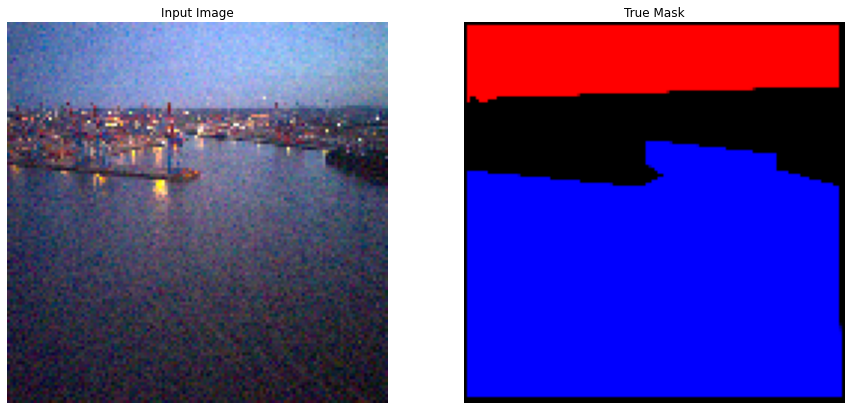

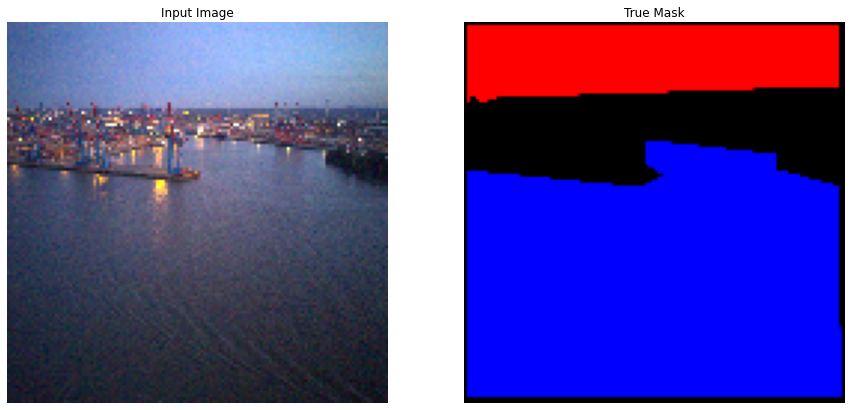

In [49]:
for images, masks in dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [50]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [51]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [52]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [53]:
OUTPUT_CLASSES = 4

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

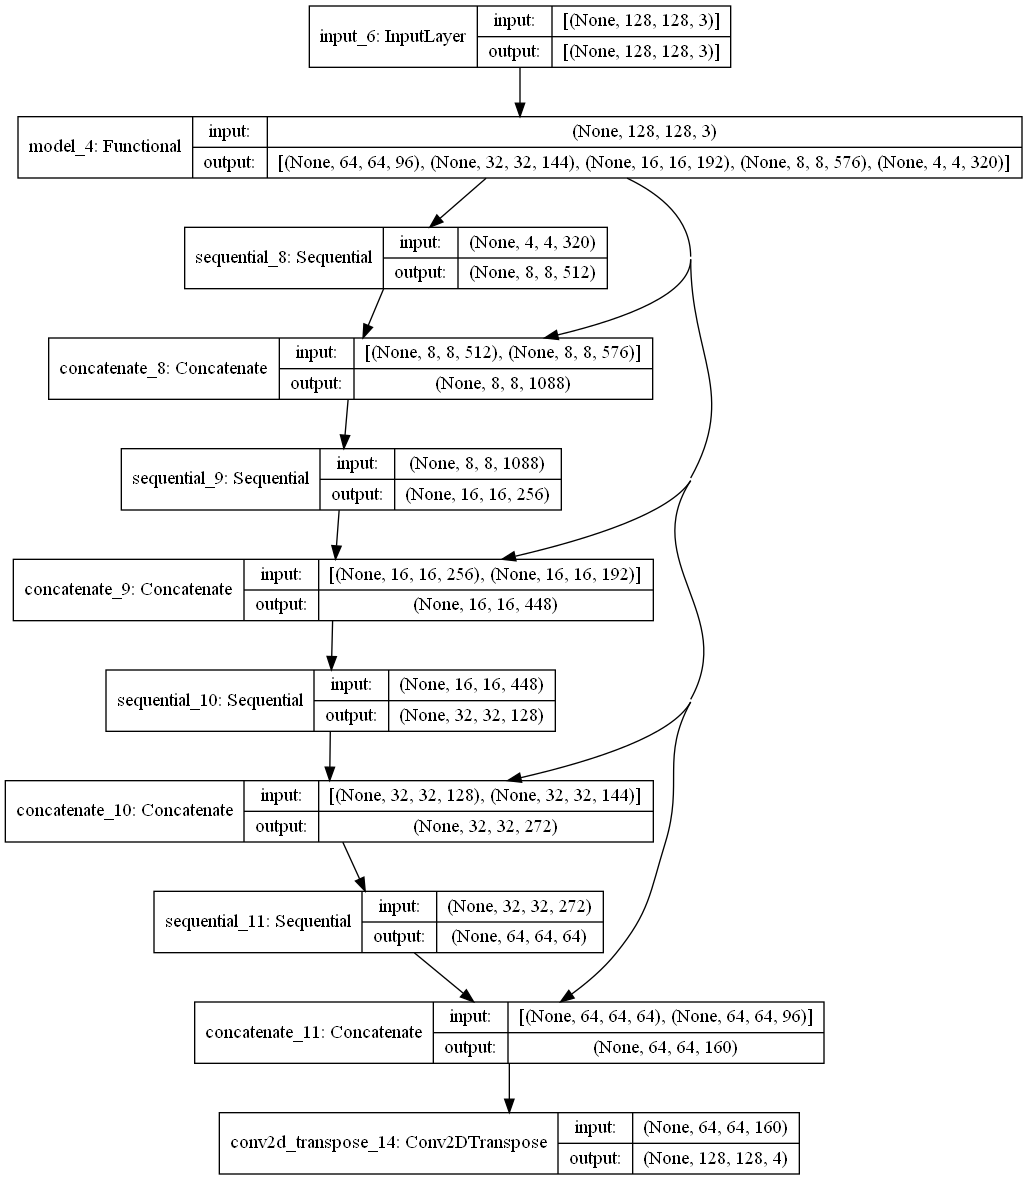

In [54]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [55]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

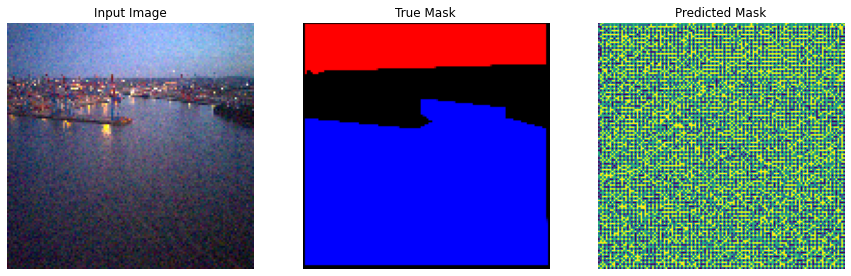

In [56]:
show_predictions(dataset=dataset)

In [57]:
val_size = int(len(IMAGE_DIR_PATH) * 0.2)
train_batches = dataset.skip(val_size)
TRAIN_LENGTH = len(IMAGE_DIR_PATH) - val_size
test_batches = dataset.take(val_size)

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_size //BATCH_SIZE // VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [58]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [59]:
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Epoch 1/20


InvalidArgumentError:  Incompatible shapes: [4] vs. [3]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Equal (defined at C:\Users\Emily\AppData\Local\Temp/ipykernel_19888/2939585661.py:1) ]] [Op:__inference_train_function_39366]

Function call stack:
train_function
